In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import matplotlib
import copy

In [2]:
hdu = fits.open('BD262606_kast_red_1.fits')
data = hdu[0].data
header = hdu[0].header

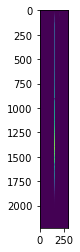

In [3]:
plt.imshow(data)

In [4]:
print (np.shape(data))

(2227, 291)


In [5]:
print (np.shape(data[0]))

(291,)


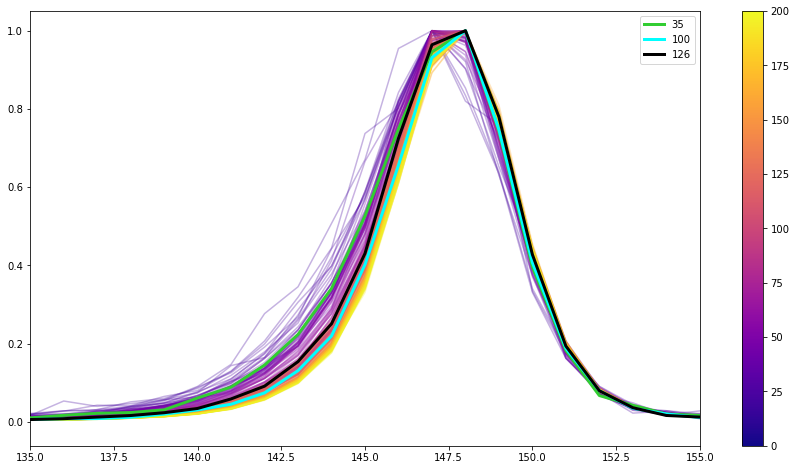

In [6]:
plt.figure(figsize=[15,8])
num_cols = 200
norm = matplotlib.colors.Normalize(vmin=0,vmax=num_cols)
c_m = matplotlib.cm.plasma
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])
x = np.arange(len(data[0]))
shift_loc = x[np.argmax(data[num_cols])]
new_x = x
cols = {'35':(35,'limegreen'),'100':(100,'cyan'),'126':(126,'black')}
# cols = [126]

for i in range(20,num_cols):
    sca = 1./np.amax(data[i])
#     sca=1.
    max_loc = x[np.argmax(data[i])]
#     new_x = x + (shift_loc-max_loc)
    if str(i) in cols:
        plt.plot(new_x, sca*data[cols[str(i)][0]], color=cols[str(i)][1], zorder=10, lw=3, label=str(i))
    else:
        plt.plot(new_x, sca*data[i], color=s_m.to_rgba(i),alpha=.3)
# plt.xlim(130,220)
plt.xlim(135,155)
# plt.ylim(0,100)
plt.colorbar(s_m)
plt.legend()
plt.show()

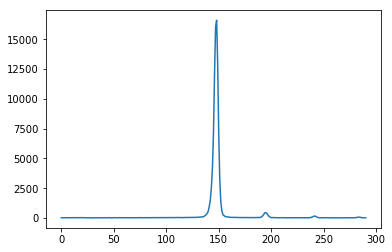

In [7]:
# plt.plot(x, data[30])
# plt.plot(x, data[100])
plt.plot(x, data[126])
plt.show()

# Trace Removal

In [8]:
from scipy.optimize import curve_fit

In [9]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def psf(x,p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, plot=False):
    p = [p0, p1, p2, p3, p4, p5, p6, p7, p8, p9]
    if plot:
        plt.figure(figsize=[10,10])
        plt.plot(x, data[i][source_xlo:source_xhi])
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[1], p[2], p[3]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[4], p[5], p[6]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[7], p[8], p[9]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), psf(np.arange(source_xlo, source_xhi, step=.1), p0, p1, p2, p3, p4, p5, p6, p7, p8, p9), color='k',lw=3)
#         plt.ylim(-500, 5000)
        plt.show()
    return p[0] + gaus(x,p[1],p[2],p[3]) + gaus(x,p[4],p[5],p[6]) + gaus(x,p[7],p[8],p[9])

def psf_simp(x, p0, p1, p4, p7, plot=False):
    p = [p0, p1, p2, p3, p4, p5, p6, p7, p8, p9]
    if plot:
        print (p)
        plt.figure(figsize=[10,10])
        plt.plot(x, data[i][source_xlo:source_xhi])
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[1], p[2], p[3]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[4], p[5], p[6]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), p[0] + gaus(np.arange(source_xlo, source_xhi, step=.1), p[7], p[8], p[9]))
        plt.plot(np.arange(source_xlo, source_xhi, step=.1), psf(np.arange(source_xlo, source_xhi, step=.1), p0, p1, p2, p3, p4, p5, p6, p7, p8, p9), color='k',lw=3)
#         plt.ylim(-500, 5000)
        plt.show()
    return p[0] + gaus(x,p[1],p[2],p[3]) + gaus(x,p[4],p[5],p[6]) + gaus(x,p[7],p[8],p[9])

def set_const_params(n2, n3, n5, n6, n8, n9):
    global p2, p3, p5, p6, p8, p9
    p2 = n2
    p3 = n3
    p5 = n5
    p6 = n6
    p8 = n8
    p9 = n9

In [10]:
ghost_xlo = [183, 230, 270]
ghost_xhi = [203, 250, 290]

ghost_ylo = 0
#ghost_yhi = 220
#ghost_yhi = 120
#ghost_yhi = 105
source_xlo = 120
source_xhi = 160
print (len(data))
print (len(data[0]))

2227
291


In [11]:
start = 200
end = 1700
# end = len(data)
x = np.arange(len(data[0]))
trace_fits = []
p_guess = [400, 35000, 147, 2.5, 10000, 147, 5, 750, 147, 5]
bounds = ((0, 2000), (5000, 50000), (120, 160), (0, 10), (5000, 20000), (120, 160), (0, 10), (0, 1000), (120, 160), (3, 10))
# bounds = ((0, np.inf), (0, np.inf), (0, 1000), (0, np.inf), (0, np.inf), (0, 1000), (0, np.inf), (0, np.inf), (0, 1000), (0, np.inf))
bounds = np.transpose(bounds)
p = p_guess
for i in range(start,end):
    
    peak = np.amax(data[i][source_xlo:source_xhi])
    p_guess = [400, .9*peak, 147, 2.5, .2*peak, 147, 5, .015*peak, 147, 5]
    bounds = ((0, 2000), (.14*peak, 1.2*peak), (120, 160), (0, 10), (.14*peak, .38*peak), (120, 160), (0, 10), (0, .03*peak), (120, 160), (3, 10))
    bounds = np.transpose(bounds)
#     if i != start:
#         p_guess = trace_fits[-1]
#     plt.plot(x[source_xlo:source_xhi], data[i][source_xlo:source_xhi])
#     plt.show()
    p, pcov = curve_fit(psf,x[source_xlo:source_xhi], data[i][source_xlo:source_xhi], p0=p_guess, bounds=bounds)
    
#     psf(x[source_xlo:source_xhi], p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], plot=True)
    print (i, p)
    trace_fits.append(p)
    plt.show()

(200, array([5.89205539e+01, 2.43614866e+04, 1.47807819e+02, 1.55808938e+00,
       7.03894561e+03, 1.47096261e+02, 2.77522713e+00, 4.49118893e+02,
       1.46363736e+02, 6.27271199e+00]))
(201, array([5.12169911e+01, 2.60240794e+04, 1.47780481e+02, 1.60529748e+00,
       5.69404242e+03, 1.46964439e+02, 2.95402715e+00, 3.23017873e+02,
       1.46571523e+02, 7.18727622e+00]))
(202, array([6.08790454e+01, 2.49299045e+04, 1.47818505e+02, 1.61726656e+00,
       5.84061833e+03, 1.46938000e+02, 2.76260208e+00, 7.13275237e+02,
       1.46771126e+02, 5.44109609e+00]))
(203, array([5.64391550e+01, 2.50393937e+04, 1.47807775e+02, 1.60278963e+00,
       6.27082372e+03, 1.46982378e+02, 2.92440070e+00, 2.97206487e+02,
       1.46385364e+02, 7.22448699e+00]))
(204, array([6.84863771e+01, 2.39595927e+04, 1.47842030e+02, 1.53078463e+00,
       7.76693331e+03, 1.47156422e+02, 2.66173987e+00, 6.29063300e+02,
       1.46343964e+02, 5.36342134e+00]))
(205, array([6.89691696e+01, 2.33220810e+04, 1.47844513

(246, array([6.70366126e+01, 2.47930474e+04, 1.47864228e+02, 1.52336999e+00,
       7.78022123e+03, 1.47192085e+02, 2.59483968e+00, 7.70070721e+02,
       1.46628351e+02, 5.23210059e+00]))
(247, array([5.86628304e+01, 2.60409257e+04, 1.47812470e+02, 1.56280629e+00,
       6.77018964e+03, 1.47159942e+02, 2.81347392e+00, 3.79260727e+02,
       1.46384575e+02, 6.60928181e+00]))
(248, array([6.42947366e+01, 2.61670164e+04, 1.47862080e+02, 1.55765015e+00,
       6.86146288e+03, 1.47062381e+02, 2.74057338e+00, 4.75347925e+02,
       1.47018528e+02, 6.05077334e+00]))
(249, array([6.20072168e+01, 2.06006669e+04, 1.47955953e+02, 1.42533499e+00,
       1.20722146e+04, 1.47358465e+02, 2.30326063e+00, 1.00176187e+03,
       1.46571465e+02, 5.04058625e+00]))
(250, array([6.39859009e+01, 2.65692202e+04, 1.47887054e+02, 1.59964702e+00,
       5.83765551e+03, 1.46855946e+02, 2.54547513e+00, 9.73146738e+02,
       1.47257145e+02, 5.06365202e+00]))
(251, array([6.91515802e+01, 2.36128820e+04, 1.47857857

(295, array([5.64623052e+01, 2.61635790e+04, 1.47844731e+02, 1.51082617e+00,
       7.43808645e+03, 1.47281105e+02, 2.73402080e+00, 3.90473392e+02,
       1.46504542e+02, 6.31405710e+00]))
(296, array([6.66487924e+01, 2.13575174e+04, 1.47897735e+02, 1.41557465e+00,
       1.16477442e+04, 1.47493794e+02, 2.31819222e+00, 1.01373199e+03,
       1.46513603e+02, 4.80125556e+00]))
(297, array([6.21582397e+01, 2.40058518e+04, 1.47878324e+02, 1.50330842e+00,
       8.66168873e+03, 1.47359417e+02, 2.42703599e+00, 1.00511566e+03,
       1.46694729e+02, 4.91992172e+00]))
(298, array([6.49981768e+01, 2.69869304e+04, 1.47883091e+02, 1.55276245e+00,
       6.24972759e+03, 1.47045115e+02, 2.59529726e+00, 8.92598597e+02,
       1.47191156e+02, 4.94797792e+00]))
(299, array([5.44837120e+01, 2.78450545e+04, 1.47836788e+02, 1.56544105e+00,
       5.93684673e+03, 1.47105698e+02, 2.89266250e+00, 2.71832356e+02,
       1.47247261e+02, 7.48753814e+00]))
(300, array([6.59939474e+01, 2.19823488e+04, 1.47893103

(345, array([6.44783866e+01, 2.64290251e+04, 1.47859485e+02, 1.48378907e+00,
       8.22326476e+03, 1.47371760e+02, 2.57562223e+00, 6.12011264e+02,
       1.46608109e+02, 5.33733239e+00]))
(346, array([5.08009426e+01, 2.81620170e+04, 1.47853449e+02, 1.52806944e+00,
       6.68801664e+03, 1.47246802e+02, 2.82901296e+00, 2.23684466e+02,
       1.46996299e+02, 8.10757595e+00]))
(347, array([9.17300707e+01, 2.53254309e+04, 1.47854949e+02, 1.38148338e+00,
       9.79228546e+03, 1.47910309e+02, 2.42686829e+00, 1.05779250e+03,
       1.44435839e+02, 3.00000000e+00]))
(348, array([6.34873807e+01, 2.90815309e+04, 1.47858704e+02, 1.48809984e+00,
       6.03778384e+03, 1.47443025e+02, 2.94266670e+00, 2.63266463e+02,
       1.44998829e+02, 5.81184964e+00]))
(349, array([8.14051323e+01, 3.03175666e+04, 1.47807746e+02, 1.52529220e+00,
       4.94641164e+03, 1.47677462e+02, 3.01105603e+00, 5.54116485e+02,
       1.43715370e+02, 3.00000000e+00]))
(350, array([5.75327800e+01, 2.46199004e+04, 1.47883778

(392, array([5.89024672e+01, 2.71475050e+04, 1.47849471e+02, 1.47978349e+00,
       8.38341014e+03, 1.47376728e+02, 2.48170343e+00, 7.58260761e+02,
       1.46972353e+02, 5.18794291e+00]))
(393, array([6.26522638e+01, 2.16223581e+04, 1.47883619e+02, 1.36749387e+00,
       1.37064575e+04, 1.47518563e+02, 2.19093265e+00, 1.08208875e+03,
       1.46873023e+02, 4.78352436e+00]))
(394, array([6.38143749e+01, 2.58685225e+04, 1.47874230e+02, 1.44249522e+00,
       1.01119184e+04, 1.47404785e+02, 2.35197769e+00, 8.98567525e+02,
       1.47089474e+02, 4.97949029e+00]))
(395, array([7.63680162e+01, 2.50140384e+04, 1.47823443e+02, 1.40024045e+00,
       1.10793176e+04, 1.47616526e+02, 2.33530632e+00, 1.10454293e+03,
       1.46392015e+02, 4.26398427e+00]))
(396, array([5.55078010e+01, 2.94878412e+04, 1.47822828e+02, 1.50417549e+00,
       7.03795105e+03, 1.47313536e+02, 2.74077360e+00, 3.27767510e+02,
       1.46882840e+02, 6.71538799e+00]))
(397, array([6.52486833e+01, 2.33671561e+04, 1.47901342

(440, array([6.04273739e+01, 2.84257998e+04, 1.47838823e+02, 1.45857300e+00,
       8.58538139e+03, 1.47352815e+02, 2.41117658e+00, 9.45717656e+02,
       1.47194569e+02, 4.81418517e+00]))
(441, array([6.49396706e+01, 2.46911647e+04, 1.47840967e+02, 1.39463875e+00,
       1.21943786e+04, 1.47524366e+02, 2.22613392e+00, 1.13009637e+03,
       1.46835156e+02, 4.56330486e+00]))
(442, array([5.95595337e+01, 2.91771671e+04, 1.47817273e+02, 1.48015731e+00,
       8.17012052e+03, 1.47384244e+02, 2.51485201e+00, 6.31434839e+02,
       1.46857716e+02, 5.45452220e+00]))
(443, array([6.25475104e+01, 2.91502975e+04, 1.47814996e+02, 1.49169427e+00,
       7.48792383e+03, 1.47317346e+02, 2.40167209e+00, 1.11449730e+03,
       1.47258417e+02, 4.64086532e+00]))
(444, array([5.60975160e+01, 2.79582984e+04, 1.47825433e+02, 1.45054989e+00,
       9.34267630e+03, 1.47384391e+02, 2.46450055e+00, 6.04913863e+02,
       1.46913529e+02, 5.50401930e+00]))
(445, array([5.97356184e+01, 2.92599082e+04, 1.47818946

(492, array([5.62583130e+01, 2.43615594e+04, 1.47764493e+02, 1.43071042e+00,
       7.45179495e+03, 1.47340771e+02, 2.42788469e+00, 6.54807484e+02,
       1.47204898e+02, 5.12222637e+00]))
(493, array([5.51000813e+01, 2.17824797e+04, 1.47835071e+02, 1.34090536e+00,
       1.27273190e+04, 1.47456712e+02, 2.14143590e+00, 1.05291129e+03,
       1.47046428e+02, 4.69851023e+00]))
(494, array([6.12121585e+01, 2.74431125e+04, 1.47809871e+02, 1.43723775e+00,
       8.25880327e+03, 1.47268021e+02, 2.32730935e+00, 1.08023941e+03,
       1.47427827e+02, 4.58709905e+00]))
(495, array([6.16080074e+01, 2.78678080e+04, 1.47790632e+02, 1.44674576e+00,
       8.52661028e+03, 1.47358674e+02, 2.29870875e+00, 1.10585613e+03,
       1.47228486e+02, 4.60755317e+00]))
(496, array([5.72898185e+01, 2.85532812e+04, 1.47766242e+02, 1.44414698e+00,
       8.58876411e+03, 1.47396025e+02, 2.45628175e+00, 6.52944092e+02,
       1.47087722e+02, 5.29449989e+00]))
(497, array([5.68351071e+01, 2.93468933e+04, 1.47777815

(545, array([6.33861001e+01, 2.95065681e+04, 1.47743167e+02, 1.42132844e+00,
       9.49258526e+03, 1.47308535e+02, 2.26668678e+00, 1.17761625e+03,
       1.47274791e+02, 4.57576633e+00]))
(546, array([5.43465782e+01, 3.17881558e+04, 1.47702916e+02, 1.45275355e+00,
       7.84369544e+03, 1.47317252e+02, 2.59883041e+00, 4.14010180e+02,
       1.47239681e+02, 6.32946535e+00]))
(547, array([6.35608457e+01, 2.99431715e+04, 1.47728735e+02, 1.44132357e+00,
       8.86396341e+03, 1.47308386e+02, 2.29710678e+00, 1.17055477e+03,
       1.47400699e+02, 4.52948163e+00]))
(548, array([6.53582132e+01, 2.96537070e+04, 1.47736007e+02, 1.42491003e+00,
       9.31558584e+03, 1.47320847e+02, 2.28779039e+00, 1.17954961e+03,
       1.47366397e+02, 4.55763979e+00]))
(549, array([5.91026607e+01, 2.55320322e+04, 1.47749074e+02, 1.35259279e+00,
       1.35573926e+04, 1.47424293e+02, 2.12072932e+00, 1.18609395e+03,
       1.47096215e+02, 4.66839769e+00]))
(550, array([6.44044309e+01, 2.93359976e+04, 1.47736946

(594, array([6.17565834e+01, 2.85051995e+04, 1.47663836e+02, 1.37372389e+00,
       1.13959520e+04, 1.47360923e+02, 2.26200291e+00, 8.85039328e+02,
       1.47010209e+02, 4.90882583e+00]))
(595, array([6.53376297e+01, 2.90747901e+04, 1.47680024e+02, 1.41266347e+00,
       1.06332143e+04, 1.47274611e+02, 2.17899960e+00, 1.19693227e+03,
       1.47334986e+02, 4.59147973e+00]))
(596, array([6.28677749e+01, 2.51356976e+04, 1.47666076e+02, 1.29920262e+00,
       1.52255921e+04, 1.47429569e+02, 2.12817152e+00, 9.28551334e+02,
       1.46816707e+02, 4.86453727e+00]))
(597, array([6.17536492e+01, 2.49348296e+04, 1.47689747e+02, 1.34125644e+00,
       1.46866125e+04, 1.47376215e+02, 2.06873522e+00, 1.19340152e+03,
       1.47130623e+02, 4.66517965e+00]))
(598, array([6.19693754e+01, 2.64748579e+04, 1.47714269e+02, 1.36614157e+00,
       1.32463289e+04, 1.47317300e+02, 2.08877510e+00, 1.19521617e+03,
       1.47215391e+02, 4.69009798e+00]))
(599, array([5.41983135e+01, 3.07967813e+04, 1.47613957

(644, array([6.30961738e+01, 2.45599683e+04, 1.47616687e+02, 1.32312828e+00,
       1.41251909e+04, 1.47325527e+02, 2.06997799e+00, 1.14302227e+03,
       1.47027576e+02, 4.53933002e+00]))
(645, array([5.79541419e+01, 2.52815678e+04, 1.47605649e+02, 1.32518989e+00,
       1.35449499e+04, 1.47308546e+02, 2.07718494e+00, 1.15093992e+03,
       1.47082703e+02, 4.62900922e+00]))
(646, array([6.36863416e+01, 2.96072295e+04, 1.47561939e+02, 1.42505371e+00,
       8.56883138e+03, 1.47214772e+02, 2.25322625e+00, 1.12926492e+03,
       1.47330991e+02, 4.48926651e+00]))
(647, array([5.45046285e+01, 3.04866568e+04, 1.47551881e+02, 1.42198196e+00,
       8.21933066e+03, 1.47250233e+02, 2.36229373e+00, 7.96728918e+02,
       1.47074391e+02, 4.95370134e+00]))
(648, array([5.63149177e+01, 2.92117781e+04, 1.47559201e+02, 1.39483339e+00,
       9.63724592e+03, 1.47274794e+02, 2.33935580e+00, 6.63941317e+02,
       1.47071512e+02, 5.22153259e+00]))
(649, array([5.65699938e+01, 3.00878298e+04, 1.47554213

(692, array([5.87698046e+01, 3.22302758e+04, 1.47468002e+02, 1.43746700e+00,
       7.17780296e+03, 1.47125085e+02, 2.46766345e+00, 6.62309730e+02,
       1.47284218e+02, 5.09798745e+00]))
(693, array([6.01162592e+01, 2.88916174e+04, 1.47509099e+02, 1.39716242e+00,
       1.00788829e+04, 1.47127258e+02, 2.16353224e+00, 1.14249738e+03,
       1.47237368e+02, 4.53776047e+00]))
(694, array([6.10073697e+01, 2.60642611e+04, 1.47485088e+02, 1.33846375e+00,
       1.30821452e+04, 1.47263514e+02, 2.08752403e+00, 1.14871594e+03,
       1.46988805e+02, 4.52117079e+00]))
(695, array([5.88319670e+01, 2.99696600e+04, 1.47502412e+02, 1.40934201e+00,
       9.12429882e+03, 1.47117449e+02, 2.22434337e+00, 1.14966434e+03,
       1.47216522e+02, 4.48107180e+00]))
(696, array([5.20505629e+01, 3.09214835e+04, 1.47447893e+02, 1.40856276e+00,
       8.40971255e+03, 1.47207920e+02, 2.40942654e+00, 6.35713665e+02,
       1.46769139e+02, 5.26323895e+00]))
(697, array([4.96062158e+01, 3.03862046e+04, 1.47469813

(742, array([5.47714606e+01, 2.72071426e+04, 1.47390667e+02, 1.36426035e+00,
       9.66519254e+03, 1.47117073e+02, 2.19083023e+00, 8.95681774e+02,
       1.47029400e+02, 4.63463413e+00]))
(743, array([4.54399760e+01, 2.83138643e+04, 1.47368725e+02, 1.37143192e+00,
       8.74502302e+03, 1.47114013e+02, 2.34920662e+00, 5.02710749e+02,
       1.46765401e+02, 5.77049763e+00]))
(744, array([5.73693531e+01, 2.45432859e+04, 1.47387941e+02, 1.33493392e+00,
       1.15340132e+04, 1.47150455e+02, 2.08734745e+00, 1.06961283e+03,
       1.46955349e+02, 4.42283931e+00]))
(745, array([5.38152351e+01, 2.75703432e+04, 1.47368864e+02, 1.38074422e+00,
       8.69826922e+03, 1.47107281e+02, 2.26273870e+00, 8.54101894e+02,
       1.46910132e+02, 4.72296516e+00]))
(746, array([4.70820008e+01, 2.93305025e+04, 1.47352400e+02, 1.38045794e+00,
       8.34986276e+03, 1.47086399e+02, 2.42977635e+00, 3.91838393e+02,
       1.46886455e+02, 5.96483164e+00]))
(747, array([4.97297651e+01, 2.92471319e+04, 1.47352619

(786, array([5.67705413e+01, 2.49837659e+04, 1.47270934e+02, 1.30499689e+00,
       1.27012084e+04, 1.47104531e+02, 2.09656751e+00, 8.83501986e+02,
       1.46780323e+02, 4.67204725e+00]))
(787, array([6.03080845e+01, 2.73833282e+04, 1.47289851e+02, 1.35738407e+00,
       9.91853860e+03, 1.47013164e+02, 2.14054243e+00, 1.13532996e+03,
       1.47024024e+02, 4.40173003e+00]))
(788, array([6.59655779e+01, 2.72347425e+04, 1.47289181e+02, 1.35673641e+00,
       1.01960786e+04, 1.47021037e+02, 2.11472099e+00, 1.13685879e+03,
       1.46915204e+02, 4.41577998e+00]))
(789, array([6.64875527e+01, 2.55224379e+04, 1.47301267e+02, 1.32032663e+00,
       1.19356096e+04, 1.47019394e+02, 2.07501175e+00, 1.14191484e+03,
       1.46965627e+02, 4.40770673e+00]))
(790, array([6.32132781e+01, 2.53576172e+04, 1.47288475e+02, 1.33001151e+00,
       1.21959782e+04, 1.47042337e+02, 2.05044559e+00, 1.14027047e+03,
       1.46999007e+02, 4.41940655e+00]))
(791, array([6.11121123e+01, 2.32762395e+04, 1.47300961

(839, array([5.24885353e+01, 2.91663418e+04, 1.47150071e+02, 1.36474285e+00,
       9.32704456e+03, 1.46892424e+02, 2.24943236e+00, 7.61676654e+02,
       1.46923853e+02, 4.90370978e+00]))
(840, array([5.04088278e+01, 2.36466672e+04, 1.47192503e+02, 1.28423270e+00,
       1.47464066e+04, 1.46938373e+02, 1.96115953e+00, 1.17994711e+03,
       1.46812465e+02, 4.46820914e+00]))
(841, array([5.65919971e+01, 2.79770221e+04, 1.47168934e+02, 1.34563128e+00,
       1.02851096e+04, 1.46888363e+02, 2.13455298e+00, 1.08269885e+03,
       1.46952689e+02, 4.41449450e+00]))
(842, array([5.37052947e+01, 2.64190427e+04, 1.47150634e+02, 1.31613569e+00,
       1.21312380e+04, 1.46953526e+02, 2.08079619e+00, 1.01504164e+03,
       1.46734804e+02, 4.59840581e+00]))
(843, array([5.33197036e+01, 2.53981328e+04, 1.47200029e+02, 1.32231743e+00,
       1.27734640e+04, 1.46880394e+02, 2.00880903e+00, 1.17019758e+03,
       1.46957382e+02, 4.46485507e+00]))
(844, array([5.13077271e+01, 2.90350422e+04, 1.47135461

(885, array([5.51890337e+01, 2.28429012e+04, 1.47065165e+02, 1.25525876e+00,
       1.47781599e+04, 1.46859018e+02, 1.97357778e+00, 1.16669684e+03,
       1.46698846e+02, 4.33649513e+00]))
(886, array([4.99282336e+01, 2.96023115e+04, 1.47004384e+02, 1.35930155e+00,
       8.50504846e+03, 1.46812586e+02, 2.32830076e+00, 5.53052752e+02,
       1.46544515e+02, 5.29841872e+00]))
(887, array([4.85990887e+01, 2.76779014e+04, 1.47025823e+02, 1.33695656e+00,
       1.01783603e+04, 1.46827231e+02, 2.20040969e+00, 7.39974975e+02,
       1.46546243e+02, 4.90800920e+00]))
(888, array([5.08523549e+01, 2.95746932e+04, 1.47011860e+02, 1.37353787e+00,
       8.40828149e+03, 1.46775157e+02, 2.29972993e+00, 5.90880218e+02,
       1.46574664e+02, 5.32282079e+00]))
(889, array([5.65897771e+01, 2.29508021e+04, 1.47067056e+02, 1.26686099e+00,
       1.46654868e+04, 1.46827506e+02, 1.96099905e+00, 1.16199246e+03,
       1.46679377e+02, 4.38051654e+00]))
(890, array([5.82302603e+01, 2.76000443e+04, 1.47031864

(939, array([5.44970016e+01, 2.44715025e+04, 1.46905411e+02, 1.29864061e+00,
       1.14572552e+04, 1.46630418e+02, 2.02320897e+00, 1.10484492e+03,
       1.46743682e+02, 4.32634495e+00]))
(940, array([5.51311262e+01, 2.46196712e+04, 1.46860210e+02, 1.29064116e+00,
       1.13455627e+04, 1.46746435e+02, 2.05628773e+00, 1.10412375e+03,
       1.46181961e+02, 4.20481622e+00]))
(941, array([5.17038580e+01, 2.52915713e+04, 1.46875091e+02, 1.32689528e+00,
       1.05764847e+04, 1.46651038e+02, 2.05262917e+00, 1.10131336e+03,
       1.46579452e+02, 4.34094882e+00]))
(942, array([5.33476578e+01, 2.72991630e+04, 1.46897458e+02, 1.35175607e+00,
       8.74480144e+03, 1.46563237e+02, 2.12625956e+00, 1.10482746e+03,
       1.46728878e+02, 4.28648006e+00]))
(943, array([5.14974374e+01, 2.90985316e+04, 1.46857623e+02, 1.36869395e+00,
       7.49790765e+03, 1.46605214e+02, 2.34738583e+00, 5.77826581e+02,
       1.46514579e+02, 5.18130099e+00]))
(944, array([5.84382261e+01, 2.45859318e+04, 1.46884756

(993, array([4.95275972e+01, 2.43342987e+04, 1.46764711e+02, 1.30732397e+00,
       1.11367872e+04, 1.46439213e+02, 1.99922211e+00, 1.07677477e+03,
       1.46577400e+02, 4.43079782e+00]))
(994, array([5.69999123e+01, 2.39022731e+04, 1.46731424e+02, 1.29356639e+00,
       1.16364650e+04, 1.46485977e+02, 2.01237655e+00, 1.07196961e+03,
       1.46367062e+02, 4.33732110e+00]))
(995, array([5.92910572e+01, 2.66389421e+04, 1.46708568e+02, 1.34254904e+00,
       8.86213450e+03, 1.46483683e+02, 2.13279084e+00, 1.07469047e+03,
       1.46374007e+02, 4.20392663e+00]))
(996, array([5.32423973e+01, 2.80403447e+04, 1.46698442e+02, 1.36087036e+00,
       7.79118781e+03, 1.46474754e+02, 2.28876934e+00, 5.88533192e+02,
       1.46292778e+02, 5.11589578e+00]))
(997, array([5.59227626e+01, 2.76557458e+04, 1.46712431e+02, 1.37597219e+00,
       7.55857341e+03, 1.46376296e+02, 2.13978278e+00, 1.06548082e+03,
       1.46533817e+02, 4.36590064e+00]))
(998, array([5.50333008e+01, 2.42398587e+04, 1.46707820

(1044, array([5.95619682e+01, 2.19648331e+04, 1.46577226e+02, 1.25517034e+00,
       1.24295728e+04, 1.46383157e+02, 1.98447679e+00, 1.01057977e+03,
       1.46163047e+02, 4.41971460e+00]))
(1045, array([5.94708154e+01, 2.65659136e+04, 1.46544152e+02, 1.34325833e+00,
       7.88036772e+03, 1.46324414e+02, 2.21399275e+00, 7.90789205e+02,
       1.46260003e+02, 4.61380057e+00]))
(1046, array([5.54870895e+01, 2.38311635e+04, 1.46581563e+02, 1.29462388e+00,
       1.06759552e+04, 1.46305100e+02, 2.03805100e+00, 1.01223516e+03,
       1.46296021e+02, 4.28275538e+00]))
(1047, array([5.14153513e+01, 2.54324529e+04, 1.46568550e+02, 1.35097177e+00,
       8.56438286e+03, 1.46220355e+02, 2.07504707e+00, 9.99230977e+02,
       1.46539143e+02, 4.40621656e+00]))
(1048, array([5.38360814e+01, 2.83937400e+04, 1.46537372e+02, 1.36964156e+00,
       6.38143198e+03, 1.46214978e+02, 2.40638657e+00, 4.85904158e+02,
       1.46404175e+02, 5.21371039e+00]))
(1049, array([5.30252902e+01, 2.45994811e+04, 1.46

(1097, array([4.91087842e+01, 2.42688592e+04, 1.46400359e+02, 1.31526848e+00,
       8.98881272e+03, 1.46113153e+02, 2.06692717e+00, 9.92932500e+02,
       1.46158814e+02, 4.33279714e+00]))
(1098, array([4.38334319e+01, 2.71752010e+04, 1.46357556e+02, 1.35184002e+00,
       6.61135381e+03, 1.46101582e+02, 2.42570595e+00, 3.29957677e+02,
       1.46077232e+02, 5.85449415e+00]))
(1099, array([4.61820693e+01, 2.43165676e+04, 1.46393292e+02, 1.32261413e+00,
       8.68464378e+03, 1.46107159e+02, 2.07991253e+00, 9.85924336e+02,
       1.46191209e+02, 4.35480046e+00]))
(1100, array([4.56119043e+01, 2.72229982e+04, 1.46367507e+02, 1.37946400e+00,
       6.04442804e+03, 1.46048084e+02, 2.35639216e+00, 5.54817613e+02,
       1.46167969e+02, 4.96345766e+00]))
(1101, array([5.25175197e+01, 2.69220743e+04, 1.46378685e+02, 1.38298530e+00,
       5.85444069e+03, 1.45975317e+02, 2.21759328e+00, 9.87641014e+02,
       1.46263190e+02, 4.19101987e+00]))
(1102, array([4.45178742e+01, 2.48217593e+04, 1.46

(1150, array([4.88785353e+01, 2.36324679e+04, 1.46210806e+02, 1.31161190e+00,
       7.93488241e+03, 1.45928517e+02, 2.10493829e+00, 9.26177401e+02,
       1.45974637e+02, 4.21914721e+00]))
(1151, array([4.40720254e+01, 2.15363321e+04, 1.46191305e+02, 1.27888685e+00,
       9.99613759e+03, 1.46020806e+02, 2.00783897e+00, 9.69968906e+02,
       1.45901384e+02, 4.25310068e+00]))
(1152, array([4.75329984e+01, 2.24499990e+04, 1.46158982e+02, 1.28037100e+00,
       9.09530197e+03, 1.46062362e+02, 2.07382487e+00, 9.13317179e+02,
       1.45605943e+02, 4.23770983e+00]))
(1153, array([4.45354318e+01, 2.33354060e+04, 1.46205456e+02, 1.31794061e+00,
       8.06097184e+03, 1.45920635e+02, 2.09899146e+00, 9.58788691e+02,
       1.45941685e+02, 4.26260957e+00]))
(1154, array([4.62679070e+01, 2.43638401e+04, 1.46184754e+02, 1.33090618e+00,
       7.29976157e+03, 1.45893445e+02, 2.13393916e+00, 9.69100312e+02,
       1.45979883e+02, 4.25260458e+00]))
(1155, array([4.42354029e+01, 2.12558689e+04, 1.46

(1197, array([5.11708824e+01, 2.23717599e+04, 1.46049671e+02, 1.29887744e+00,
       9.02890881e+03, 1.45772933e+02, 2.03996325e+00, 9.38769972e+02,
       1.45724009e+02, 4.25730108e+00]))
(1198, array([5.09541049e+01, 2.12505636e+04, 1.46030981e+02, 1.28336126e+00,
       1.00660436e+04, 1.45808616e+02, 2.00340658e+00, 9.69122051e+02,
       1.45720437e+02, 4.20832717e+00]))
(1199, array([4.55113954e+01, 2.34381221e+04, 1.46019241e+02, 1.30719279e+00,
       8.27385565e+03, 1.45789682e+02, 2.12460584e+00, 7.26181520e+02,
       1.45656195e+02, 4.62222139e+00]))
(1200, array([5.04675055e+01, 2.49987458e+04, 1.46023693e+02, 1.35749644e+00,
       6.43696912e+03, 1.45681217e+02, 2.22651246e+00, 7.59898457e+02,
       1.45919029e+02, 4.40266324e+00]))
(1201, array([4.57939126e+01, 2.44985013e+04, 1.46001260e+02, 1.32954868e+00,
       7.20010717e+03, 1.45731123e+02, 2.21047210e+00, 7.02008789e+02,
       1.45842550e+02, 4.59070307e+00]))
(1202, array([5.01261006e+01, 2.50277860e+04, 1.46

(1244, array([3.76687178e+01, 2.65582318e+04, 1.45840774e+02, 1.36148602e+00,
       5.52910378e+03, 1.45518739e+02, 2.49137207e+00, 3.18134077e+02,
       1.45706860e+02, 5.75474787e+00]))
(1245, array([4.73474315e+01, 2.15149841e+04, 1.45863090e+02, 1.27532138e+00,
       1.00076386e+04, 1.45608913e+02, 2.00637061e+00, 9.67122012e+02,
       1.45525186e+02, 4.23005906e+00]))
(1246, array([4.52106456e+01, 2.22978796e+04, 1.45817833e+02, 1.27777339e+00,
       9.47233200e+03, 1.45681938e+02, 2.06795586e+00, 8.21515638e+02,
       1.45187565e+02, 4.39240756e+00]))
(1247, array([4.38554186e+01, 1.94538663e+04, 1.45875181e+02, 1.23290729e+00,
       1.23693295e+04, 1.45616881e+02, 1.90684334e+00, 9.76526016e+02,
       1.45539770e+02, 4.38743333e+00]))
(1248, array([3.98861673e+01, 2.50421757e+04, 1.45823691e+02, 1.33211818e+00,
       6.95628882e+03, 1.45568601e+02, 2.29266304e+00, 4.52739593e+02,
       1.45447048e+02, 5.33464455e+00]))
(1249, array([4.73479450e+01, 1.92039333e+04, 1.45

(1298, array([4.67084789e+01, 2.49366612e+04, 1.45624951e+02, 1.31399124e+00,
       7.12648842e+03, 1.45367612e+02, 2.26981361e+00, 5.02135529e+02,
       1.45323823e+02, 5.11797712e+00]))
(1299, array([5.47002981e+01, 2.32021622e+04, 1.45622467e+02, 1.30918085e+00,
       8.11826569e+03, 1.45392330e+02, 2.08477188e+00, 9.31365176e+02,
       1.45266108e+02, 4.30197574e+00]))
(1300, array([5.51249847e+01, 2.02851002e+04, 1.45653443e+02, 1.25769079e+00,
       1.10550589e+04, 1.45405738e+02, 1.95446226e+00, 9.36093340e+02,
       1.45398098e+02, 4.37244232e+00]))
(1301, array([5.66634445e+01, 2.38720400e+04, 1.45616653e+02, 1.31874381e+00,
       7.72117608e+03, 1.45359690e+02, 2.13076085e+00, 7.71169160e+02,
       1.45429991e+02, 4.44834328e+00]))
(1302, array([5.99055196e+01, 2.12627780e+04, 1.45659767e+02, 1.27857283e+00,
       1.03518147e+04, 1.45331279e+02, 1.95023698e+00, 9.40315254e+02,
       1.45512426e+02, 4.37440295e+00]))
(1303, array([6.18874351e+01, 2.24371212e+04, 1.45

(1352, array([6.09903954e+01, 2.13293317e+04, 1.45408120e+02, 1.25999409e+00,
       1.00373818e+04, 1.45247383e+02, 2.00702505e+00, 9.39861094e+02,
       1.44791892e+02, 4.23377057e+00]))
(1353, array([5.79580469e+01, 2.38956384e+04, 1.45391261e+02, 1.32120982e+00,
       7.49775228e+03, 1.45191652e+02, 2.19340875e+00, 6.33498986e+02,
       1.44942281e+02, 4.83536142e+00]))
(1354, array([6.71323486e+01, 2.34193657e+04, 1.45422215e+02, 1.30266742e+00,
       8.22402768e+03, 1.45133796e+02, 2.14518473e+00, 6.80479735e+02,
       1.44997371e+02, 4.66517458e+00]))
(1355, array([6.72406579e+01, 2.10309310e+04, 1.45403687e+02, 1.24806538e+00,
       1.06371846e+04, 1.45220990e+02, 2.02134561e+00, 8.15908663e+02,
       1.44862445e+02, 4.47518081e+00]))
(1356, array([6.47380450e+01, 2.39419160e+04, 1.45391286e+02, 1.30997647e+00,
       7.70658366e+03, 1.45136288e+02, 2.15844883e+00, 7.70213577e+02,
       1.44961784e+02, 4.51182426e+00]))
(1357, array([6.47734133e+01, 2.39976869e+04, 1.45

(1407, array([5.51958828e+01, 2.08922765e+04, 1.45214354e+02, 1.24437972e+00,
       1.09543402e+04, 1.44948470e+02, 1.95553322e+00, 9.78110098e+02,
       1.44866991e+02, 4.27184743e+00]))
(1408, array([5.02250107e+01, 2.46816601e+04, 1.45184099e+02, 1.32452490e+00,
       7.18733597e+03, 1.44866694e+02, 2.21925497e+00, 6.00713465e+02,
       1.44867616e+02, 4.82749157e+00]))
(1409, array([5.73687832e+01, 2.28079848e+04, 1.45191372e+02, 1.30445691e+00,
       8.56586897e+03, 1.44911715e+02, 2.03327692e+00, 9.63870059e+02,
       1.44966195e+02, 4.23453786e+00]))
(1410, array([5.44919241e+01, 2.33185124e+04, 1.45189203e+02, 1.30757140e+00,
       8.11983376e+03, 1.44886318e+02, 2.05328229e+00, 9.63201855e+02,
       1.44928645e+02, 4.26845069e+00]))
(1411, array([4.96816802e+01, 2.38372129e+04, 1.45191546e+02, 1.32412418e+00,
       7.50452762e+03, 1.44860789e+02, 2.07426759e+00, 9.60853301e+02,
       1.44995984e+02, 4.21760773e+00]))
(1412, array([4.44936336e+01, 2.07174195e+04, 1.45

(1465, array([3.91417305e+01, 2.49206022e+04, 1.44909347e+02, 1.34255894e+00,
       5.47907041e+03, 1.44654238e+02, 2.45450878e+00, 3.20908793e+02,
       1.44411499e+02, 5.95416722e+00]))
(1466, array([4.71888546e+01, 2.24181165e+04, 1.44921408e+02, 1.31756618e+00,
       6.98469992e+03, 1.44651450e+02, 2.11416972e+00, 9.05025762e+02,
       1.44593317e+02, 4.34297753e+00]))
(1467, array([4.29182007e+01, 2.17293273e+04, 1.44949865e+02, 1.30488470e+00,
       7.94680954e+03, 1.44618761e+02, 2.02749058e+00, 9.12104180e+02,
       1.44646969e+02, 4.37434236e+00]))
(1468, array([4.72582902e+01, 1.95562439e+04, 1.44946344e+02, 1.23297312e+00,
       1.04244310e+04, 1.44718490e+02, 1.95548934e+00, 9.24926016e+02,
       1.44487247e+02, 4.33098728e+00]))
(1469, array([3.73006162e+01, 2.37467273e+04, 1.44899896e+02, 1.35123613e+00,
       5.79279200e+03, 1.44606812e+02, 2.28335407e+00, 5.38547240e+02,
       1.44483754e+02, 4.94221527e+00]))
(1470, array([4.14612120e+01, 2.20282985e+04, 1.44

(1517, array([4.16224247e+01, 2.12269702e+04, 1.44693487e+02, 1.31286560e+00,
       6.67385950e+03, 1.44409994e+02, 2.10995033e+00, 8.38981289e+02,
       1.44512136e+02, 4.34943292e+00]))
(1518, array([4.14186689e+01, 1.97556267e+04, 1.44727789e+02, 1.27799606e+00,
       8.32328286e+03, 1.44370706e+02, 2.02969566e+00, 8.42179277e+02,
       1.44515909e+02, 4.43792461e+00]))
(1519, array([3.97596231e+01, 2.05211437e+04, 1.44688961e+02, 1.29620538e+00,
       7.94524424e+03, 1.44478055e+02, 2.04996989e+00, 8.57358340e+02,
       1.44172742e+02, 4.42315041e+00]))
(1520, array([3.36735200e+01, 2.44772400e+04, 1.44659922e+02, 1.36803057e+00,
       4.45269410e+03, 1.44331226e+02, 2.55736750e+00, 3.00072588e+02,
       1.44308714e+02, 6.03362721e+00]))
(1521, array([3.27321627e+01, 2.19602204e+04, 1.44665603e+02, 1.30311053e+00,
       6.54523101e+03, 1.44421070e+02, 2.24238932e+00, 5.07454383e+02,
       1.44281836e+02, 5.23866048e+00]))
(1522, array([3.79855015e+01, 2.32207916e+04, 1.44

(1573, array([5.02157794e+01, 1.39339873e+04, 1.44434925e+02, 1.26834676e+00,
       5.39790038e+03, 1.44212460e+02, 2.11774427e+00, 4.23982864e+02,
       1.43953741e+02, 4.92338335e+00]))
(1574, array([4.11017966e+01, 1.37457538e+04, 1.44434024e+02, 1.25965499e+00,
       5.50803158e+03, 1.44226300e+02, 2.04516700e+00, 5.70841582e+02,
       1.43881391e+02, 4.45638723e+00]))
(1575, array([4.08024120e+01, 1.27239539e+04, 1.44390664e+02, 1.26152580e+00,
       5.29026047e+03, 1.44273343e+02, 2.08859095e+00, 5.40746895e+02,
       1.43675519e+02, 4.37244954e+00]))
(1576, array([2.80924102e+01, 1.44700746e+04, 1.44380470e+02, 1.36287218e+00,
       2.64723896e+03, 1.44029937e+02, 2.64039087e+00, 1.58452038e+02,
       1.43982673e+02, 6.76502135e+00]))
(1577, array([3.22770769e+01, 1.31879707e+04, 1.44401045e+02, 1.31946538e+00,
       3.30102836e+03, 1.44079849e+02, 2.36748523e+00, 2.67037864e+02,
       1.43788603e+02, 5.57922826e+00]))
(1578, array([3.28847550e+01, 1.15905406e+04, 1.44

(1618, array([6.07221757e+01, 1.20438974e+04, 1.44251988e+02, 1.26570860e+00,
       4.87762644e+03, 1.43972112e+02, 2.08349574e+00, 5.16518203e+02,
       1.43775159e+02, 4.93930027e+00]))
(1619, array([4.88497961e+01, 1.43082008e+04, 1.44247235e+02, 1.26398833e+00,
       5.26782698e+03, 1.43996803e+02, 2.06897239e+00, 5.99099062e+02,
       1.43757536e+02, 4.66295742e+00]))
(1620, array([3.87025840e+01, 1.41986620e+04, 1.44203419e+02, 1.23562581e+00,
       6.95439826e+03, 1.44077482e+02, 1.98424431e+00, 6.50977207e+02,
       1.43667979e+02, 4.61190037e+00]))
(1621, array([4.03831933e+01, 1.32282933e+04, 1.44177899e+02, 1.23608439e+00,
       7.05904062e+03, 1.44058783e+02, 1.97166134e+00, 6.27530391e+02,
       1.43707576e+02, 4.57707226e+00]))
(1622, array([6.02652118e+01, 1.60065107e+04, 1.44159598e+02, 1.34284358e+00,
       3.28806716e+03, 1.43870625e+02, 2.72522680e+00, 5.68660601e+01,
       1.36188931e+02, 3.00000000e+00]))
(1623, array([5.05273972e+01, 1.24032841e+04, 1.44

(1665, array([5.51254409e+01, 1.09298389e+04, 1.43976121e+02, 1.18016278e+00,
       7.10811078e+03, 1.43861963e+02, 1.96642971e+00, 5.61166641e+02,
       1.43157692e+02, 5.04333726e+00]))
(1666, array([5.00178423e+01, 1.38279698e+04, 1.43974832e+02, 1.30136629e+00,
       4.38913457e+03, 1.43750880e+02, 2.27268393e+00, 3.77826607e+02,
       1.43455147e+02, 5.78955332e+00]))
(1667, array([7.64787456e+01, 1.69268970e+04, 1.43971241e+02, 1.35419973e+00,
       3.01003608e+03, 1.43725259e+02, 2.89524338e+00, 5.72644345e+01,
       1.35583364e+02, 3.00000000e+00]))
(1668, array([5.24110136e+01, 1.58183681e+04, 1.43971029e+02, 1.29485757e+00,
       5.01310924e+03, 1.43784061e+02, 2.16049134e+00, 6.45853125e+02,
       1.43477522e+02, 4.81758229e+00]))
(1669, array([3.83833183e+01, 1.62490563e+04, 1.43953640e+02, 1.27650451e+00,
       5.29526224e+03, 1.43751519e+02, 2.22312495e+00, 4.43676831e+02,
       1.43585637e+02, 5.58829278e+00]))
(1670, array([4.09937877e+01, 1.59047309e+04, 1.43

In [12]:
def poly_param_fit(fits_T, start, pi, order = 3, stop=1700):
    x_fit = np.arange(start,stop)
#     print (len(x_fit), len(fits_T[pi][0:stop-start]))
    plt.plot(x_fit, fits_T[pi][0:stop-start])
    pfit = np.polyfit(x_fit,fits_T[pi][0:stop-start], order)
    pfit = np.flip(pfit)
    
    x_new = np.arange(0,stop)
    y_fit = np.zeros(len(x_new))
    for i, p in enumerate(pfit):
        y_fit += pfit[i]*(x_new**i)
#     y_fit = pfit[0]*x**3 + pfit[1]*x**2 + pfit[2]*x + pfit[3]
    return x_new, y_fit

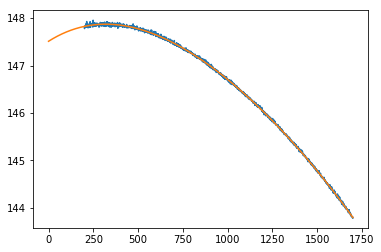

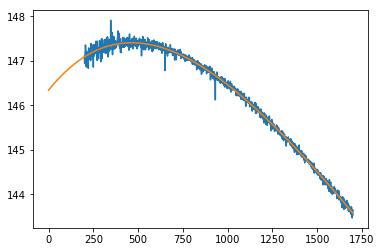

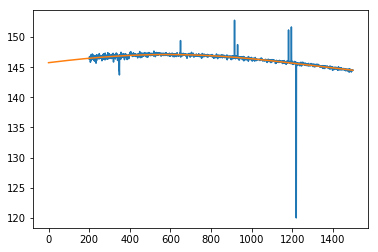

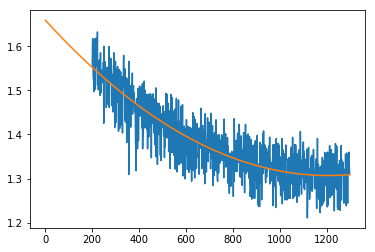

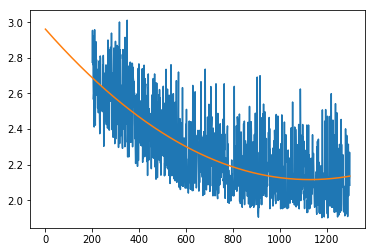

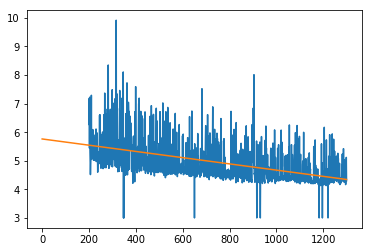

In [13]:
fits_T = np.transpose(trace_fits)
x_new, y_fit_2 = poly_param_fit(fits_T, start, 2, order = 4)
plt.plot(x_new, y_fit_2)
plt.show()

x_new, y_fit_5 = poly_param_fit(fits_T, start, 5, order = 4)
plt.plot(x_new, y_fit_5)
plt.show()

x_new, y_fit_8 = poly_param_fit(fits_T, start, 8, order = 4, stop=1500)
plt.plot(x_new, y_fit_8)
plt.show()

x_new, y_fit_3 = poly_param_fit(fits_T, start, 3, order = 2, stop =1300)
plt.plot(x_new, y_fit_3)
plt.show()

x_new, y_fit_6 = poly_param_fit(fits_T, start, 6, order = 2, stop =1300)
plt.plot(x_new, y_fit_6)
plt.show()

x_new, y_fit_9 = poly_param_fit(fits_T, start, 9, order = 1, stop =1300)
plt.plot(x_new, y_fit_9)
plt.show()

In [14]:
new_data = copy.deepcopy(data)

begin = 0
end = 1300
# end = len(data)
x = np.arange(len(data[0]))
trace_fits = []
# bounds = ((0, np.inf), (0, np.inf), (0, 1000), (0, np.inf), (0, np.inf), (0, 1000), (0, np.inf), (0, np.inf), (0, 1000), (0, np.inf))
bounds = np.transpose(bounds)
for i in range(begin,end):
    
    peak = np.amax(data[i][source_xlo:source_xhi])
    p_guess = [10, .9*peak, .2*peak, .015*peak]
    bounds = ((0,1000),(.14*peak, 1.2*peak), (.14*peak, .38*peak), (0, .03*peak))
    bounds = np.transpose(bounds)
    set_const_params(y_fit_2[i], y_fit_3[i], y_fit_5[i], y_fit_6[i], y_fit_8[i], y_fit_9[i])
    p, pcov = curve_fit(psf_simp, x[source_xlo:source_xhi], data[i][source_xlo:source_xhi], p0=p_guess, bounds=bounds)
    
#     psf_model = psf_simp(x[source_xlo:source_xhi], p[0], p[1], p[2], p[3], p[4], p[5], p[6], plot=True)
    psf_model = psf_simp(x[source_xlo:source_xhi], p[0], p[1], p[2], p[3], plot=False)
    
    new_data[i][source_xlo:source_xhi] = data[i][source_xlo:source_xhi] - psf_model + p[0]
#     psf(x[source_xlo:source_xhi], p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], plot=True)
#     print (i, p)
#     trace_fits.append(p)
    plt.show()

<IPython.core.display.Javascript object>


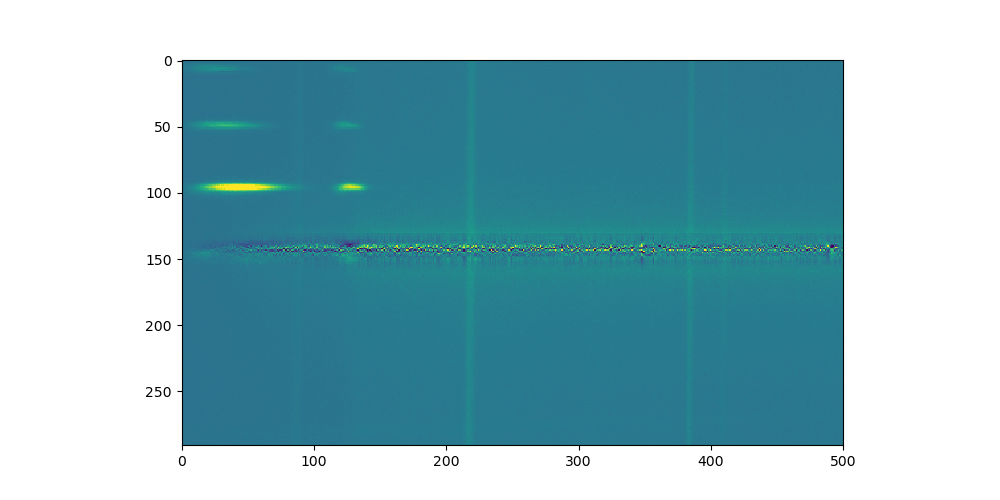

In [15]:
%matplotlib notebook
plt.figure(figsize=[10,5])
new_data_rot = np.rot90(new_data, k=1)
plt.imshow(new_data_rot, vmin=-300, vmax=500)
# plt.xlim(1000,1200)
plt.xlim(0,500)
plt.show()

In [16]:
hdu = fits.PrimaryHDU(new_data,header)
hdu.writeto('std_sub.fits',output_verify='ignore')

In [17]:
type(fits)

module